In [ ]:
#importing libraries
import numpy as np
import pandas as pd

#import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
#Import matplotlib and create a helper function to plot graphs
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
#Converting the dataframe to Tensorflow Dataset 

features = 'text'
target = 'label'

dataset_train = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_data[features].values, tf.string),
            tf.cast(test_data[target].values, tf.int64)
        )
    )
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(dataset_test_csv[features].values, tf.string),
            tf.cast(dataset_test_csv[target].values, tf.int64)
        )
    )
)

print("datatype of dataset_train   :", type(dataset_train))
print("datatype of dataset_test    :",type(dataset_test))

datatype of dataset_train   : <class 'tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset'>
datatype of dataset_test    : <class 'tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset'>


In [ ]:
#Verifying loading of tf.dataset
for example, label in dataset_train.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b"The movie starts out with some scrolling text which takes nearly five minutes. It gives the basic summary of what is going on. This could have easily been done with acting but instead you get a scrolling text effect. Soon after you are bombarded with characters that you learn a little about, keep in mind this is ALL you will learn about them. The plot starts to get off the ground and then crashes through the entire movie. Not only does the plot change, but you might even ask yourself if your watching the same movie. I have never played the video game, but know people who have. From my understanding whether you've played the game or not this movie does not get any better. Save your money unless you like to sleep at the theaters."
 b"Im proud to say I've seen all three Fast and Furious films.Sure,the plots are kinda silly,and they might be a little cheesy,but I love them car chases,and all the beautiful cars,and the clandestine midnight races.And Ill gladly see a fourth one.<br

In [ ]:
#Next shuffle the data for training and create batches of these (text, label) pairs
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Create the text encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(dataset_train.map(lambda text, label: text))

In [ ]:
#the .adapt method sets the layer's vocabulary
#first 20 tokens (sorted by frequency)
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
#the layer is ready to encode text into indices
#the tensor of indices will be 0-padded to the longest sequence
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 74,  10, 404, ...,   0,   0,   0],
       [  2,   1, 114, ...,   0,   0,   0],
       [ 10, 208,  11, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
#With the default settings, the process is not completely reversible. There are three main reasons for that:

# 1. The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".
# 2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.


#demonstartion of limitations
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"The movie starts out with some scrolling text which takes nearly five minutes. It gives the basic summary of what is going on. This could have easily been done with acting but instead you get a scrolling text effect. Soon after you are bombarded with characters that you learn a little about, keep in mind this is ALL you will learn about them. The plot starts to get off the ground and then crashes through the entire movie. Not only does the plot change, but you might even ask yourself if your watching the same movie. I have never played the video game, but know people who have. From my understanding whether you've played the game or not this movie does not get any better. Save your money unless you like to sleep at the theaters."
Round-trip:  the movie starts out with some [UNK] [UNK] which takes nearly five minutes it gives the [UNK] [UNK] of what is going on this could have easily been done with acting but instead you get a [UNK] [UNK] effect soon after you are [UNK] with

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[0.0104313]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 72ms/step
[0.0016314]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(dataset_train, epochs=10,
                    validation_data=dataset_test,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 48s 97ms/step - loss: 0.6430 - accuracy: 0.6050 - val_loss: 1.3267 - val_accuracy: 5.2083e-04
Epoch 2/10
391/391 [==============================] - 24s 61ms/step - loss: 0.6636 - accuracy: 0.5668 - val_loss: 1.2048 - val_accuracy: 0.0698
Epoch 3/10
391/391 [==============================] - 25s 65ms/step - loss: 0.5844 - accuracy: 0.6701 - val_loss: 0.9827 - val_accuracy: 0.6792
Epoch 4/10
391/391 [==============================] - 23s 58ms/step - loss: 0.4406 - accuracy: 0.7811 - val_loss: 0.5988 - val_accuracy: 0.8229
Epoch 5/10
391/391 [==============================] - 22s 57ms/step - loss: 0.3240 - accuracy: 0.8642 - val_loss: 0.6174 - val_accuracy: 0.8016
Epoch 6/10
391/391 [==============================] - 23s 58ms/step - loss: 0.2950 - accuracy: 0.8766 - val_loss: 0.5313 - val_accuracy: 0.8161
Epoch 7/10
391/391 [==============================] - 23s 58ms/step - loss: 0.2812 - accuracy: 0.8824 - val_loss: 0.4554 - val_accur

In [ ]:
test_loss, test_acc = model.evaluate(dataset_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3459 - accuracy: 0.8614
Test Loss: 0.34587863087654114
Test Accuracy: 0.8613600134849548


(0.0, 1.3800700902938843)

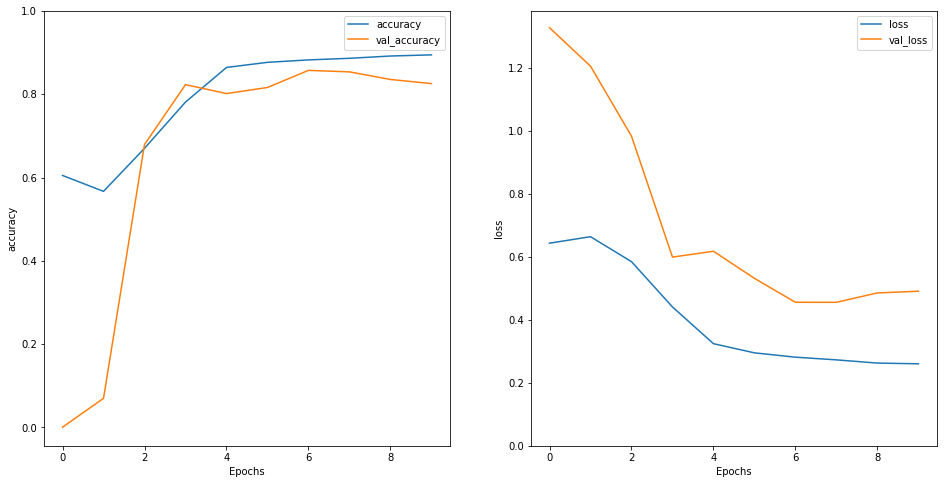

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 2s 2s/step


array([[1.5191172]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(dataset_train, epochs=10,
                    validation_data=dataset_test,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 23s 59ms/step - loss: 0.2570 - accuracy: 0.8911 - val_loss: 0.5047 - val_accuracy: 0.8224
Epoch 2/10
391/391 [==============================] - 22s 57ms/step - loss: 0.2526 - accuracy: 0.8970 - val_loss: 0.4596 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 24s 61ms/step - loss: 0.2482 - accuracy: 0.8973 - val_loss: 0.4703 - val_accuracy: 0.8396
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 0.2498 - accuracy: 0.8974 - val_loss: 0.5229 - val_accuracy: 0.8104
Epoch 5/10
391/391 [==============================] - 24s 60ms/step - loss: 0.2439 - accuracy: 0.8979 - val_loss: 0.6637 - val_accuracy: 0.7484
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.2504 - accuracy: 0.8976 - val_loss: 0.4501 - val_accuracy: 0.8505
Epoch 7/10
391/391 [==============================] - 24s 62ms/step - loss: 0.2407 - accuracy: 0.9017 - val_loss: 0.5384 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 44ms/step - loss: 0.3265 - accuracy: 0.8628
Test Loss: 0.32652056217193604
Test Accuracy: 0.8628399968147278


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 9s 9s/step
[[-1.6878362]]


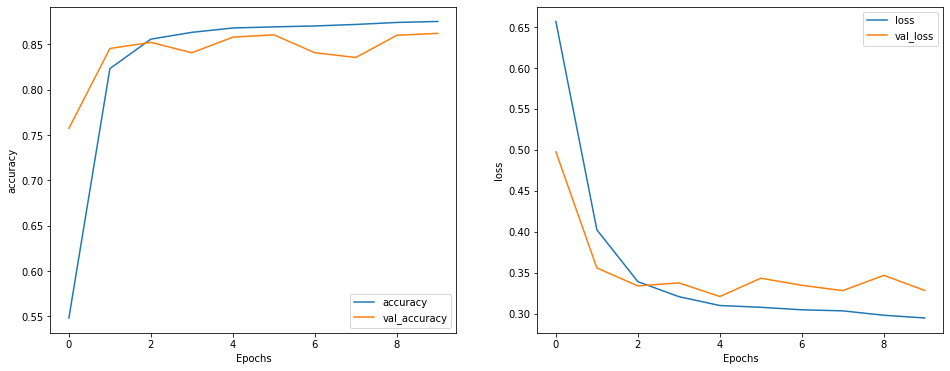

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')